# Generate Data

In [1]:
# Imports
from pathlib import Path
from tqdm import tqdm
from elements import elements
from mendeleev import element

from Code.cifSimulation import structureGenerator
from Code.h5Constructor import h5Constructor

import cProfile

## Cif generation

In [2]:
# Path to dataset
datasetPath = './Dataset/CIFs/SimulatedTest2/'

# Initialize the CIF generator
generator = structureGenerator()

# Maximum number of atom species in generated structures
n_species = 2

# Choose required atoms to use
required_atoms = ['O']

# Choose optional atoms to use
metals = [atom.Symbol for atom in elements.Alkali_Metals] 
metals += [atom.Symbol for atom in elements.Alkaline_Earth_Metals] 
metals += [atom.Symbol for atom in elements.Transition_Metals] 
metals += [atom.Symbol for atom in elements.Metalloids] 
metals += [atom.Symbol for atom in elements.Others]

optional_atoms = []
for metal in metals:
    try:
        elm_data = element(metal)
        if elm_data.metallic_radius or elm_data.atomic_radius:
            optional_atoms.append(metal)
        else:
            print(f'Removed {metal} from dataset as no table values were available.')
    except:
        print(f'Removed {metal} from dataset as no table values were available.')
optional_atoms = ['Zn', 'Nb']

# Simulate mono-metal oxides
generator.create_cif_dataset(
    n_species=n_species,
    required_atoms=required_atoms,
    optional_atoms=optional_atoms,
    from_table_values=False,
    save_folder=datasetPath,
)

Removed Fr from dataset as no table values were available.
Removed Bh from dataset as no table values were available.
Removed Db from dataset as no table values were available.
Removed Hs from dataset as no table values were available.
Removed Mt from dataset as no table values were available.
Removed Rf from dataset as no table values were available.
Removed Sg from dataset as no table values were available.
Removed Uub from dataset as no table values were available.
Removed Uun from dataset as no table values were available.
Removed Uuu from dataset as no table values were available.


Calculating cell parameter approximations: 100%|██████████| 14/14 [01:48<00:00,  7.78s/it]


Simulating CIFs


Structure types: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


## Query COD

In [1]:
from pathlib import Path
import requests
import zipfile
import io
from multiprocessing import Pool, cpu_count
from itertools import islice, repeat
from tqdm.auto import tqdm
import argparse
from elements import elements
from mendeleev import element
import pandas as pd

In [2]:
metals = [atom.Symbol for atom in elements.Alkali_Metals] 
metals += [atom.Symbol for atom in elements.Alkaline_Earth_Metals] 
metals += [atom.Symbol for atom in elements.Transition_Metals] 
metals += [atom.Symbol for atom in elements.Metalloids] 
metals += [atom.Symbol for atom in elements.Others] # Post-transition metals
metals += ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
           'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu'] # Lanthanides

# Remove elements that does not have a well defined radius or are rare in nanoparticles
unwanted_elements = ['Fr', 'Po', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Uub', 'Uun', 'Uuu']
for elm in unwanted_elements:
    metals.remove(elm)
    
print(len(metals))

68


In [3]:
non_metals = [atom.Symbol for atom in elements.Non_Metals]
non_metals += [atom.Symbol for atom in elements.Halogens]
non_metals.remove('At')

print(len(non_metals))

10


In [4]:
# Find all possible two element combinations of metals and non-metals
combinations = []
for metal in metals:
    for non_metal in non_metals:
        combinations.append(([metal, non_metal], []))

for metal in metals:
    combinations.append(([metal], non_metals))

print(len(combinations))

748


In [5]:
def queryCOD_new(input_tuple):
    (included_atoms, excluded_atoms), max_volume = input_tuple

    id_url = 'https://www.crystallography.net/cod/result?format=lst'
    if included_atoms:
        for i, included_atom in enumerate(included_atoms):
            id_url += f'&el{i+1}={included_atom}'
    if excluded_atoms:
        for i, excluded_atom in enumerate(excluded_atoms):
            id_url += f'&nel{i+1}={excluded_atom}'
    if max_volume:
        id_url += f'&vmax={max_volume}'
    
    id_response = requests.get(id_url)

    return id_response.text.split('\n')

In [6]:
inputs = zip(combinations, repeat(1000))
id_list = []
with Pool(processes=cpu_count()-1) as pool:
    with tqdm(total=len(combinations), desc='Querying COD') as pbar:
        for returned_ids in pool.imap_unordered(queryCOD_new, inputs, chunksize=1):
            id_list.extend(returned_ids)
            pbar.update()

Querying COD:   0%|          | 0/748 [00:00<?, ?it/s]

In [8]:
df_ids = pd.DataFrame(id_list)
print(len(df_ids))
df_ids = df_ids.drop_duplicates()
print(len(df_ids))
df_ids.to_csv('./test_cif_IDs.csv', index=False, header=False)

171342
61795


In [4]:
from Code.cifCleaning import cif_cleaning_pipeline
from Code.databaseQuery import queryCOD

# Path to dataset
cif_folder = './Dataset/CIFs/COD_subset/'

# Path to CIF ID list
id_list_path = './COD_subset_IDs.csv'

queryCOD(cif_folder, id_file=id_list_path)

In [5]:
df_cifs = cif_cleaning_pipeline(cif_folder, chunksize=100)

Cleaning CIFs:   0%|          | 0/61794 [00:00<?, ?it/s]

Summary of corrected errors in cif dataset

	Removed: 913
	Loop error: 10935
	Precision error: 32992
	Parenthesis error: 0
	Unwanted atom: 0
	Timeout: 0


CIFs containing no metals removed!
60872 CIFs --> 60618 CIFs


In [6]:
df_cifs.head()

filepath  Spacegroup  Element0  \
0  ./Dataset/CIFs/COD_subset_cleaned/4122844.cif           2         1   
1  ./Dataset/CIFs/COD_subset_cleaned/8106818.cif           2         1   
2  ./Dataset/CIFs/COD_subset_cleaned/4001305.cif           2         8   
3  ./Dataset/CIFs/COD_subset_cleaned/1535718.cif          57         8   
4  ./Dataset/CIFs/COD_subset_cleaned/1540113.cif         225         9   

   Element1  Element2  Element3  Element4  Element5  Element6  Element7  \
0       5.0       6.0       8.0       NaN       NaN       NaN       NaN   
1       6.0       7.0       8.0      29.0       NaN       NaN       NaN   
2      12.0      38.0      42.0       NaN       NaN       NaN       NaN   
3      29.0      57.0       NaN       NaN       NaN       NaN       NaN   
4      19.0      22.0      55.0       NaN       NaN       NaN       NaN   

   Element8  Element9  Element10  
0       NaN       NaN        NaN  
1       NaN       NaN        NaN  
2       NaN       NaN        NaN  
3       NaN       NaN        NaN  
4       NaN       NaN        NaN

In [7]:
df_cifs[(df_cifs['Element0'] == 6) & (df_cifs['Element1'] == 8) & (df_cifs['Element2'].isna())]

filepath  Spacegroup  Element0  \
10985  ./Dataset/CIFs/COD_subset_cleaned/1563199.cif         225         6   
13693  ./Dataset/CIFs/COD_subset_cleaned/4313234.cif          14         6   
37510  ./Dataset/CIFs/COD_subset_cleaned/7200686.cif         225         6   
37598  ./Dataset/CIFs/COD_subset_cleaned/1563205.cif         225         6   
46607  ./Dataset/CIFs/COD_subset_cleaned/1563196.cif         225         6   
56430  ./Dataset/CIFs/COD_subset_cleaned/1563202.cif         225         6   

       Element1  Element2  Element3  Element4  Element5  Element6  Element7  \
10985       8.0       NaN       NaN       NaN       NaN       NaN       NaN   
13693       8.0       NaN       NaN       NaN       NaN       NaN       NaN   
37510       8.0       NaN       NaN       NaN       NaN       NaN       NaN   
37598       8.0       NaN       NaN       NaN       NaN       NaN       NaN   
46607       8.0       NaN       NaN       NaN       NaN       NaN       NaN   
56430       8.0       NaN       NaN       NaN       NaN       NaN       NaN   

       Element8  Element9  Element10  
10985       NaN       NaN        NaN  
13693       NaN       NaN        NaN  
37510       NaN       NaN        NaN  
37598       NaN       NaN        NaN  
46607       NaN       NaN        NaN  
56430       NaN       NaN        NaN

In [13]:
from ase.io import read
cif = read(df_cifs['filepath'].iloc[19477], format='cif')

/root/anaconda3/envs/dataset_env/lib/python3.10/site-packages/ase/io/cif.py:401: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(225, setting=1). This may result in wrong setting!
  warnings.warn(


In [14]:
cif.symbols

Symbols('C4O4')

In [20]:
metals

['Cs',
 'Li',
 'K',
 'Rb',
 'Na',
 'Ba',
 'Be',
 'Ca',
 'Mg',
 'Ra',
 'Sr',
 'Cd',
 'Cr',
 'Co',
 'Cu',
 'Au',
 'Hf',
 'Ir',
 'Fe',
 'Mn',
 'Hg',
 'Mo',
 'Ni',
 'Nb',
 'Os',
 'Pd',
 'Pt',
 'Re',
 'Rh',
 'Ru',
 'Sc',
 'Ag',
 'Ta',
 'Tc',
 'Ti',
 'W',
 'V',
 'Y',
 'Zn',
 'Zr',
 'Sb',
 'As',
 'B',
 'Ge',
 'Si',
 'Te',
 'Al',
 'Bi',
 'Ga',
 'In',
 'Pb',
 'Tl',
 'Sn',
 'La',
 'Ce',
 'Pr',
 'Nd',
 'Pm',
 'Sm',
 'Eu',
 'Gd',
 'Tb',
 'Dy',
 'Ho',
 'Er',
 'Tm',
 'Yb',
 'Lu']

In [19]:
metal_numbers = [element(metal).atomic_number for metal in metals]
metal_numbers

[55,
 3,
 19,
 37,
 11,
 56,
 4,
 20,
 12,
 88,
 38,
 48,
 24,
 27,
 29,
 79,
 72,
 77,
 26,
 25,
 80,
 42,
 28,
 41,
 76,
 46,
 78,
 75,
 45,
 44,
 21,
 47,
 73,
 43,
 22,
 74,
 23,
 39,
 30,
 40,
 51,
 33,
 5,
 32,
 14,
 52,
 13,
 83,
 31,
 49,
 82,
 81,
 50,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71]

In [42]:
# df_cifs.columns.difference(['filepath', 'Spacegroup'])
contains_metals = df_cifs.apply(lambda row: any(atom in metal_numbers for atom in row[2:].values), axis=1)

In [44]:
sum(~contains_metals)

254

In [45]:
df_cifs[~contains_metals]

filepath  Spacegroup  Element0  \
716    ./Dataset/CIFs/COD_subset_cleaned/1010495.cif         221         1   
1009   ./Dataset/CIFs/COD_subset_cleaned/9015379.cif         122         1   
1152   ./Dataset/CIFs/COD_subset_cleaned/2300032.cif          14         7   
1650   ./Dataset/CIFs/COD_subset_cleaned/4321812.cif         173         1   
1769   ./Dataset/CIFs/COD_subset_cleaned/1522990.cif         125        92   
...                                              ...         ...       ...   
60281  ./Dataset/CIFs/COD_subset_cleaned/4307823.cif         194         6   
60347  ./Dataset/CIFs/COD_subset_cleaned/2300068.cif          62         6   
60684  ./Dataset/CIFs/COD_subset_cleaned/1100000.cif         166         6   
60704  ./Dataset/CIFs/COD_subset_cleaned/2102302.cif         225         7   
60767  ./Dataset/CIFs/COD_subset_cleaned/4134489.cif          33         1   

       Element1  Element2  Element3  Element4  Element5  Element6  Element7  \
716         8.0       NaN       NaN       NaN       NaN       NaN       NaN   
1009        8.0      15.0       NaN       NaN       NaN       NaN       NaN   
1152        8.0       9.0      15.0       NaN       NaN       NaN       NaN   
1650        6.0       7.0       NaN       NaN       NaN       NaN       NaN   
1769        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
60281       7.0       NaN       NaN       NaN       NaN       NaN       NaN   
60347       9.0       NaN       NaN       NaN       NaN       NaN       NaN   
60684       7.0       NaN       NaN       NaN       NaN       NaN       NaN   
60704       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
60767       7.0       8.0       9.0      15.0       NaN       NaN       NaN   

       Element8  Element9  Element10  
716         NaN       NaN        NaN  
1009        NaN       NaN        NaN  
1152        NaN       NaN        NaN  
1650        NaN       NaN        NaN  
1769        NaN       NaN        NaN  
...         ...       ...        ...  
60281       NaN       NaN        NaN  
60347       NaN       NaN        NaN  
60684       NaN       NaN        NaN  
60704       NaN       NaN        NaN  
60767       NaN       NaN        NaN  

[254 rows x 13 columns]

In [16]:
# Cout nan values
df_cifs[df_cifs['Element1'].isna()].sort_values(by='filepath')

filepath  Spacegroup  Element0  \
23355  ./Dataset/CIFs/COD_subset_cleaned/1008022.cif         211        42   
55068  ./Dataset/CIFs/COD_subset_cleaned/1008871.cif         225        77   
22833  ./Dataset/CIFs/COD_subset_cleaned/1011119.cif         225        82   
42890  ./Dataset/CIFs/COD_subset_cleaned/1100108.cif         229        26   
35325  ./Dataset/CIFs/COD_subset_cleaned/1100138.cif         225        79   
...                                              ...         ...       ...   
46229  ./Dataset/CIFs/COD_subset_cleaned/9017735.cif         229        74   
22645  ./Dataset/CIFs/COD_subset_cleaned/9017801.cif         229         3   
47408  ./Dataset/CIFs/COD_subset_cleaned/9017802.cif         166         3   
55066  ./Dataset/CIFs/COD_subset_cleaned/9017840.cif         194        26   
39863  ./Dataset/CIFs/COD_subset_cleaned/9017841.cif         194        26   

       Element1  Element2  Element3  Element4  Element5  Element6  Element7  \
23355       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
55068       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
22833       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
42890       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
35325       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
46229       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
22645       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
47408       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
55066       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
39863       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       Element8  Element9  Element10  
23355       NaN       NaN        NaN  
55068       NaN       NaN        NaN  
22833       NaN       NaN        NaN  
42890       NaN       NaN        NaN  
35325       NaN       NaN        NaN  
...         ...       ...        ...  
46229       NaN       NaN        NaN  
22645       NaN       NaN        NaN  
47408       NaN       NaN        NaN  
55066       NaN       NaN        NaN  
39863       NaN       NaN        NaN  

[1098 rows x 13 columns]

In [40]:
from ase.io import read
from tqdm.auto import trange
metal_cifs = df_cifs[df_cifs['Element1'].isna()].sort_values(by='filepath')


In [32]:
unit_cell = read(metal_cifs['filepath'].iloc[7].replace('_cleaned', ''))
print(unit_cell.get_chemical_formula())
print(unit_cell.get_chemical_symbols())
print(unit_cell.cell.cellpar())


Au4
['Au', 'Au', 'Au', 'Au']
[ 4.0427  4.0427  4.0427 90.     90.     90.    ]


In [42]:
df_cifs.columns

Index(['filepath', 'Spacegroup', 'Element0', 'Element1', 'Element2',
       'Element3', 'Element4', 'Element5', 'Element6', 'Element7', 'Element8',
       'Element9', 'Element10'],
      dtype='object')

In [43]:
columns = ['Spacegroup', 'Element0', 'Element1', 'Element2',
       'Element3', 'Element4', 'Element5', 'Element6', 'Element7', 'Element8',
       'Element9', 'Element10']
for i in trange(len(df_cifs)):
    specific_row = df_cifs.iloc[i]

    duplicate_cifs = df_cifs[(df_cifs[columns] == specific_row[columns]).all(axis=1)]
    if len(duplicate_cifs) > 0:
        print(specific_row)
        print(duplicate_cifs.head())
        break



  0%|          | 0/60872 [00:00<?, ?it/s]

filepath      ./Dataset/CIFs/COD_subset_cleaned/9013809.cif
Spacegroup                                                2
Element0                                                  1
Element1                                                8.0
Element2                                                9.0
Element3                                               11.0
Element4                                               14.0
Element5                                               19.0
Element6                                               22.0
Element7                                               25.0
Element8                                               26.0
Element9                                               30.0
Element10                                              55.0
Name: 28117, dtype: object
                                            filepath  Spacegroup  Element0  \
28117  ./Dataset/CIFs/COD_subset_cleaned/9013809.cif           2         1   

       Element1  Element2  Element3 

## .h5 generation

In [2]:
gc = h5Constructor(cif_dir='./Dataset/CIFs/SimulatedTest2/', save_dir='./Dataset/h5/SimulatedTest3/')
# cProfile.run('gc.gen_h5s(parallelize=False, device="cuda")', sort='tottime')
gc.gen_h5s(parallelize=False, device='cuda', np_radii=[5,10])

CadmiumChloride_NbO2
CadmiumIodide_ZnO2
Fluorite_NbO2
Spinel_NbNb2O4
Wurtzite_NbO
RockSalt_NbO
Wurtzite_ZnO
NickelArsenide_NbO
CaesiumChloride_ZnO
CadmiumIodide_NbO2
NickelArsenide_ZnO
Rutile_ZnO2
AntiFluorite_Zn2O
ZincBlende_ZnO
AntiFluorite_Nb2O
Spinel_ZnZn2O4
Rutile_NbO2
CaesiumChloride_NbO
RheniumTrioxide_ZnO3
RockSalt_ZnO
CadmiumChloride_ZnO2
RheniumTrioxide_NbO3
Fluorite_ZnO2
ZincBlende_NbO


## Create unit cell graph

In [1]:
#%% Imports
import os, sys, math, torch
from mendeleev import element
from mendeleev.fetch import fetch_table
import numpy as np
from tqdm.auto import tqdm
import h5py
from itertools import repeat
from multiprocessing import Pool, cpu_count
from pathlib import Path
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from networkx.algorithms.components import is_connected
from ase.io import read
from ase.build import make_supercell
from ase.spacegroup import get_spacegroup
from ase.visualize import view
# from Code.simScatteringPatterns import simPDFs, cif_to_NP_GPU
from debyecalculator import DebyeCalculator
from elements import elements
from mendeleev import element
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.core.structure import Structure
from pymatgen.analysis.local_env import CrystalNN, MinimumDistanceNN
from pymatgen.io.ase import AseAtomsAdaptor
from timeit import default_timer as timer

In [2]:
# Path to cif file
# cif = './Dataset/CIFs/COD_subset_cleaned/1000023.cif'
cif = './Dataset/CIFs/COD_subset_cleaned/1008022.cif'

# Load cif
unit_cell = read(cif)

# Find spacegroup
spacegroup = get_spacegroup(unit_cell)

/root/anaconda3/envs/dataset_env/lib/python3.10/site-packages/ase/io/cif.py:401: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(211, setting=1). This may result in wrong setting!
  warnings.warn(


In [3]:
unit_cell.get_chemical_symbols()

['Mo', 'Mo']

In [4]:
unit_cell.get_scaled_positions()

array([[0. , 0. , 0. ],
       [0.5, 0.5, 0.5]])

In [5]:
# view(unit_cell, viewer='ngl')

In [6]:
node_feature_table = fetch_table('elements')[['atomic_number', 'atomic_radius', 'atomic_weight', 'electron_affinity']]
node_feature_table['electron_affinity'].fillna(0.0, inplace=True)

# Metals of interest
metals = [atom.Symbol for atom in elements.Alkali_Metals] 
metals += [atom.Symbol for atom in elements.Alkaline_Earth_Metals] 
metals += [atom.Symbol for atom in elements.Transition_Metals] 
metals += [atom.Symbol for atom in elements.Metalloids] 
metals += [atom.Symbol for atom in elements.Others] # Post-transition metals
metals += ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
        'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu'] # Lanthanides

# Remove elements that does not have a well defined radius or are rare in nanoparticles
unwanted_elements = ['Fr', 'Po', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Uub', 'Uun', 'Uuu']
for elm in unwanted_elements:
    metals.remove(elm)
    
# Convert to atomic numbers
metals = [element(metal).atomic_number for metal in metals]

In [7]:
import plotly.graph_objects as go

def plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features):
    
    jmol_colors = [
        "#FFFFFF", "#8F8F8F", "#D9FFFF", "#CC80FF", "#C2FF00", "#FFB5B5", "#909090", "#3050F8", "#FF0D0D", "#90E050",
        "#B3E3F5", "#AB5CF2", "#8AFF00", "#BFA6A6", "#F0C8A0", "#FF8000", "#FFFF30", "#1FF01F", "#80D1E3", "#8F40D4",
        "#3DFF00", "#E6E6E6", "#BFC2C7", "#A6A6AB", "#8A99C7", "#9C7AC7", "#E06633", "#F090A0", "#50D050", "#C88033",
        "#7D80B0", "#C28F8F", "#668F8F", "#BD80E3", "#FFA100", "#A62929", "#5CB8D1", "#702EB0", "#00FF00", "#94FFFF",
        "#94E0E0", "#73C2C9", "#54B5B5", "#3B9E9E", "#248F8F", "#0A7D8C", "#006985", "#C0C0C0", "#FFD98F", "#A67573",
        "#668080", "#9E63B5", "#D47A00", "#940094", "#429EB0", "#57178F", "#00C900", "#70D4FF", "#FFFFC7", "#D9FFC7",
        "#C7FFC7", "#A3FFC7", "#8FFFC7", "#61FFC7", "#45FFC7", "#30FFC7", "#1FFFC7", "#00FF9C", "#00E675", "#00D452",
        "#00BF38", "#00AB24", "#4DC2FF", "#4DA6FF", "#2194D6", "#267DAB", "#266696", "#175487", "#D0D0E0", "#FFD123",
        "#B8B8D0", "#A6544D", "#575961", "#9E4FB5", "#AB5C00", "#754F45", "#428296", "#420066", "#007D00", "#70ABFA",
        "#00BAFF", "#00A1FF", "#008FFF", "#0080FF", "#006BFF", "#545CF2", "#785CE3", "#8A4FE3", "#A136D4", "#B31FD4",
        "#B31FBA", "#B30DA6", "#BD0D87", "#C70066", "#CC0059", "#D1004F", "#D90045", "#E00038", "#E6002E", "#EB0026",
        "#EB0026", "#F1001E"
    ]
    
    # Create a figure
    fig = go.Figure()
    
    # Add atoms to the figure
    for i in range(len(node_pos_real)):
        atom = node_pos_real[i]
        fig.add_trace(go.Scatter3d(
            x=[atom[0]],
            y=[atom[1]],
            z=[atom[2]],
            mode='markers',
            marker=dict(
                size=5,
                color=jmol_colors[int(node_features[i][0])],
            ),
            name=f'Atom {i+1}\n({node_features[i][0]})'
        ))

    # Add bonds to the figure
    for i in range(len(direction[0])):
        atom1 = node_pos_real[direction[0][i]]
        atom2 = node_pos_real[direction[1][i]]
        fig.add_trace(go.Scatter3d(
            x=[atom1[0], atom2[0]],
            y=[atom1[1], atom2[1]],
            z=[atom1[2], atom2[2]],
            mode='lines',
            line=dict(
                color='black',
                width=2
            ),
            name=f'Bond {i+1}\n({edge_features[i]:.2f})'
        ))

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        title='Atom Positions and Bonds',
        showlegend=True
    )

    # Show the figure
    fig.show()

In [8]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Make supercell to get Lattice constant
supercell = make_supercell(unit_cell, np.diag([2,2,2]))
# supercell = unit_cell
metal_distances = supercell[supercell.get_atomic_numbers() != 8].get_all_distances()
lc = np.amin(metal_distances[metal_distances > 0.])

# Create edges and node features
lc_mask = (unit_cell_dist > 0) & (unit_cell_dist < lc)
oxy_mask = np.outer(unit_cell_atoms == 8, unit_cell_atoms == 8)
metal_mask = np.outer(unit_cell_atoms != 8, unit_cell_atoms !=8)
direction = np.argwhere(lc_mask & ~oxy_mask & ~metal_mask).T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

Time to create graph: 1.29e-02 s
Number of edges: 0


In [9]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# metal_filter = np.isin(unit_cell_atoms, metals)

# Find node features
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')

# Create mask of threshold for bonds
bond_threshold = np.zeros_like(unit_cell_dist)
for i, r1 in enumerate(node_features[:,1]):
    bond_threshold[i,:] = (r1 + node_features[:,1]) / 100 * 1.25
np.fill_diagonal(bond_threshold, 0.)

# Find edges
direction = np.argwhere(unit_cell_dist < bond_threshold).T

edge_features = unit_cell_dist[direction[0], direction[1]]

node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

Time to create graph: 2.79e-03 s
Number of edges: 0


In [10]:
unit_cell_atoms.T

array([[42, 42]])

In [11]:
direction

array([], shape=(2, 0), dtype=int64)

In [12]:
node_pos_relative

array([[0. , 0. , 0. ],
       [0.5, 0.5, 0.5]])

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(unit_cell)
crystal_nn = CrystalNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(unit_cell)
crystal_nn = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False)
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction)

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(unit_cell)
minimum_nn = MinimumDistanceNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, minimum_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

## Create supercell graph

In [19]:
r_max = 10 # Maximum radius of the particle
cell_dims = unit_cell.cell.cellpar()[:3] # Get the cell dimensions
padding = 2 # Symmetric padding to ensure the particle does not exceed the supercell boundary
supercell_matrix = np.diag((np.ceil(r_max / cell_dims)) * 2 + padding)
supercell = make_supercell(prim=unit_cell, P=supercell_matrix)
# supercell = make_supercell(unit_cell, np.diag([2,2,2]))
# supercell.center(about=0)
supercell.get_positions().max(axis=0)

array([21.7735, 21.7735, 21.7735])

In [18]:
cell_dims

array([6.221, 6.221, 6.221])

In [16]:
unit_cell.get_positions().max(axis=0)

array([3.1105, 3.1105, 3.1105])

In [17]:
view(supercell, viewer='ngl')

In [208]:
from pymatgen.analysis.local_env import CrystalNN, MinimumDistanceNN, IsayevNN, JmolNN, MinimumOKeeffeNN, MinimumVIRENN, OpenBabelNN, VoronoiNN

In [36]:
# Setup of structure and local neighborhood strategies
struc = AseAtomsAdaptor.get_structure(supercell)
crystal_nn = CrystalNN()
minDist_nn = MinimumDistanceNN()
isayev_nn = IsayevNN()
jmol_nn = JmolNN()
keeffe_nn = MinimumOKeeffeNN()
viree_nn = MinimumVIRENN()
voronoi_nn = VoronoiNN()

In [37]:
# CrystalNN
start_crystalNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
stop_crystalNN = timer()
# Save number of edges
nEdges_crystalNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]


In [38]:
# MinimumDistanceNN
start_minDistNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, minDist_nn)
stop_minDistNN = timer()
# Save number of edges
nEdges_minDistNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [39]:
# IsayevNN
start_isayevNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, isayev_nn)
stop_isayevNN = timer()
# Save number of edges
nEdges_isayevNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



ValueError: No Voronoi neighbors found for site - try increasing cutoff

In [40]:
# JmolNN
start_jmolNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, jmol_nn)
stop_jmolNN = timer()
# Save number of edges
nEdges_jmolNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [41]:
# MinimumOKeeffeNN
start_okeeffeNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, keeffe_nn)
stop_okeeffeNN = timer()
# Save number of edges
nEdges_okeeffeNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [42]:
# MinimumVIRENN
start_vireeNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, viree_nn)
stop_vireeNN = timer()
# Save number of edges
nEdges_vireeNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



KeyboardInterrupt: 

In [43]:
# VoronoiNN
start_voronoiNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, voronoi_nn)
stop_voronoiNN = timer()
# Save number of edges
nEdges_voronoiNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



ValueError: No Voronoi neighbors found for site - try increasing cutoff

In [45]:
print('Timing results:')
print('_________________________________________________________')
print('Method | Time (s) | Number of edges')
print('_________________________________________________________')
print(f'CrystalNN | {stop_crystalNN-start_crystalNN:.2e} | {nEdges_crystalNN}')
print(f'MinimumDistanceNN | {stop_minDistNN-start_minDistNN:.2e} | {nEdges_minDistNN}')
# print(f'IsayevNN | {stop_isayevNN-start_isayevNN:.2e} | {nEdges_isayevNN}')
print(f'JmolNN | {stop_jmolNN-start_jmolNN:.2e} | {nEdges_jmolNN}')
print(f'MinimumOKeeffeNN | {stop_okeeffeNN-start_okeeffeNN:.2e} | {nEdges_okeeffeNN}')
# print(f'MinimumVIRENN | {stop_vireeNN-start_vireeNN:.2e} | {nEdges_vireeNN}')
# print(f'VoronoiNN | {stop_voronoiNN-start_voronoiNN:.2e} | {nEdges_voronoiNN}')
print('_________________________________________________________')

Timing results:
_________________________________________________________
Method | Time (s) | Number of edges
_________________________________________________________
CrystalNN | 1.12e+02 | 1024
MinimumDistanceNN | 1.45e+01 | 768
JmolNN | 2.03e+01 | 1088
MinimumOKeeffeNN | 1.77e+01 | 768
_________________________________________________________


In [56]:
start = timer()
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(supercell)
crystal_nn = CrystalNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = supercell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in supercell_atoms
    ], dtype='float')
node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2f} s')
print(f'Number of edges: {len(direction[0])}')
plot_atoms_and_bonds(node_pos_real, node_features, direction)

/root/anaconda3/envs/dataset_env/lib/python3.10/site-packages/pymatgen/analysis/local_env.py:4135: UserWarning:

No oxidation states specified on sites! For better results, set the site oxidation states in the structure.

/root/anaconda3/envs/dataset_env/lib/python3.10/site-packages/pymatgen/analysis/local_env.py:3928: UserWarning:

CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.



Time to create graph: 1.18e+02 s
Number of edges: 1024


In [216]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# metal_filter = np.isin(unit_cell_atoms, metals)

# Find node features
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in supercell_atoms
    ], dtype='float')

# Create mask of threshold for bonds
bond_threshold = np.zeros_like(supercell_dist)
for i, r1 in enumerate(node_features[:,1]):
    bond_threshold[i,:] = (r1 + node_features[:,1]) / 100 * 1.25
np.fill_diagonal(bond_threshold, 0.)

# Find edges
direction = np.argwhere(supercell_dist < bond_threshold).T

# Handle case with no edges
if len(direction[0]) == 0:
    min_dist = np.amin(supercell_dist[supercell_dist > 0])
    direction = np.argwhere(supercell_dist < min_dist * 1.1).T
    
edge_features = supercell_dist[direction[0], direction[1]]

node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

Time to create graph: 4.12e-03 s
Number of edges: 70


In [213]:
len(direction[0])

0

In [79]:
start = timer()
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(supercell)
crystal_nn = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False)
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = supercell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in supercell_atoms
    ], dtype='float')
node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2f} s')
print(f'Number of edges: {len(direction[0])}')
plot_atoms_and_bonds(node_pos_real, node_features, direction)

Time to create graph: 119.37 s
Number of edges: 1024


In [59]:
start = timer()
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(supercell)
minDist_nn = MinimumDistanceNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, minDist_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = supercell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in supercell_atoms
    ], dtype='float')
node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2f} s')
print(f'Number of edges: {len(direction[0])}')
plot_atoms_and_bonds(node_pos_real, node_features, direction)


Time to create graph: 14.72 s
Number of edges: 768


In [76]:
AseAtomsAdaptor.get_structure(unit_cell).make_supercell(np.diag([2,2,2]))

TypeError: Structure.make_supercell() got an unexpected keyword argument 'pbc'

## Misc

In [1]:
from mendeleev import element
from mendeleev.fetch import fetch_table

In [32]:
node_feature_table = fetch_table('elements')[['atomic_number', 'atomic_radius', 'atomic_weight', 'electron_affinity']]

In [33]:
node_feature_table.describe()

atomic_number  atomic_radius  atomic_weight  electron_affinity
count     118.000000      90.000000     118.000000          77.000000
mean       59.500000     149.844444     146.469608           0.437697
std        34.207699      40.079110      89.643663           2.880333
min         1.000000      25.000000       1.008000         -19.700000
25%        30.250000     135.000000      66.465750           0.322000
50%        59.500000     145.000000     142.574830           0.650000
75%        88.750000     178.750000     226.750000           1.165000
max       118.000000     260.000000     294.000000           3.612725

In [34]:
node_feature_table['electron_affinity'].fillna(0.0, inplace=True)

In [24]:
node_feature_table['atomic_radius']

0       25.0
1      120.0
2      145.0
3      105.0
4       85.0
       ...  
113      NaN
114      NaN
115      NaN
116      NaN
117      NaN
Name: atomic_radius, Length: 118, dtype: float64

In [23]:
node_feature_table.describe()

atomic_number  atomic_radius  atomic_weight  electron_affinity
count     118.000000      90.000000     118.000000         118.000000
mean       59.500000     149.844444     146.469608           0.285616
std        34.207699      40.079110      89.643663           2.330852
min         1.000000      25.000000       1.008000         -19.700000
25%        30.250000     135.000000      66.465750           0.000000
50%        59.500000     145.000000     142.574830           0.303500
75%        88.750000     178.750000     226.750000           0.904055
max       118.000000     260.000000     294.000000           3.612725

In [8]:
import numpy as np

# Define the element symbol
element_symbol = 'O'

# Get the row corresponding to the element symbol
element_row = node_feature_table[node_feature_table['symbol'] == element_symbol]

# Extract the required features as a numpy array
element_features = element_row[['atomic_number', 'atomic_radius', 'atomic_weight', 'electron_affinity']].to_numpy()


In [10]:
element_features.flatten()

array([ 8.       , 60.       , 15.999    ,  1.4611135])

# Load and inspect data

In [1]:
from Code.datasetClass import InOrgMatDatasets
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from mendeleev import element
from tqdm.auto import tqdm
warnings.simplefilter(action='ignore') # , category=FutureWarning

dataset = InOrgMatDatasets('Simulated_rmax60', root='./Dataset/')

Extracting Dataset/Simulated_rmax60/raw/Simulated_rmax60.zip
Processing...
Done!


In [2]:
dataset.create_data_split()
dataset.create_data_split(split_strategy='stratified', stratify_on='Crystal type')

In [3]:
dataset.load_data_split(split_strategy='stratified', stratify_on='Crystal type')

In [4]:
idx = 1
print(dataset.len())
print(dataset.get(idx).y['atomic_species'])
print(dataset.get(idx))

3240
tensor([ 9., 21.])
Data(
  x=[279, 4],
  edge_index=[2, 876],
  edge_attr=[1448],
  y={
    crystal_type='CadmiumChloride',
    space_group_symbol='C 2/m',
    space_group_number=12,
    atomic_species=[2],
    n_atomic_species=2,
    np_size=23.96804428100586,
    n_atoms=279,
    n_bonds=876,
    cell_params=[6],
    unit_cell_node_feat=[9, 4],
    unit_cell_edge_index=[2, 12],
    unit_cell_edge_feat=[18],
    unit_cell_pos_abs=[9, 3],
    unit_cell_pos_frac=[9, 3],
    nd=[2, 580],
    xrd=[2, 580],
    nPDF=[2, 6000],
    xPDF=[2, 6000],
    sans=[2, 300],
    saxs=[2, 300],
  },
  pos_frac=[279, 3],
  pos_abs=[279, 3]
)


In [5]:
print(dataset.len(split='train'), dataset.len(split='validation'), dataset.len(split='test'))
dataset.get(1, split='test')

1554 519 519


Data(
  x=[1412, 4],
  edge_index=[2, 4888],
  edge_attr=[4896],
  y={
    crystal_type='Wurtzite',
    space_group_symbol='C m c 21',
    space_group_number=36,
    atomic_species=[2],
    n_atomic_species=2,
    np_size=33.739349365234375,
    n_atoms=1412,
    n_bonds=4888,
    cell_params=[6],
    unit_cell_node_feat=[4, 4],
    unit_cell_edge_index=[2, 8],
    unit_cell_edge_feat=[8],
    unit_cell_pos_abs=[4, 3],
    unit_cell_pos_frac=[4, 3],
    nd=[2, 580],
    xrd=[2, 580],
    nPDF=[2, 5000],
    xPDF=[2, 5000],
    sans=[2, 300],
    saxs=[2, 300],
  },
  pos_frac=[1412, 3],
  pos_abs=[1412, 3]
)

## Create .xyz file

In [13]:
# Loop over all indices in the dataset
for idx in tqdm(range(dataset.len())):
    # Get the sample at an index
    # idx = 9
    sample = dataset.get(idx)

    # Extract the absolute coordinates and atomic numbers
    coords = sample.pos_abs.numpy()
    atomic_numbers = sample.x[:,0].numpy().astype(int)
    n_atoms = sample.y['n_atoms']

    # Write the .xyz file
    with open(f'./Dataset/xyz/SimulatedTest2/{idx}.xyz', 'w') as f:
        f.write(f'{n_atoms}\n')
        f.write('\n')
        for i in range(n_atoms):
            f.write(f'{element(int(atomic_numbers[i])).symbol} {coords[i,0]} {coords[i,1]} {coords[i,2]}\n')


  0%|          | 0/48 [00:00<?, ?it/s]

## Plotting and statistics

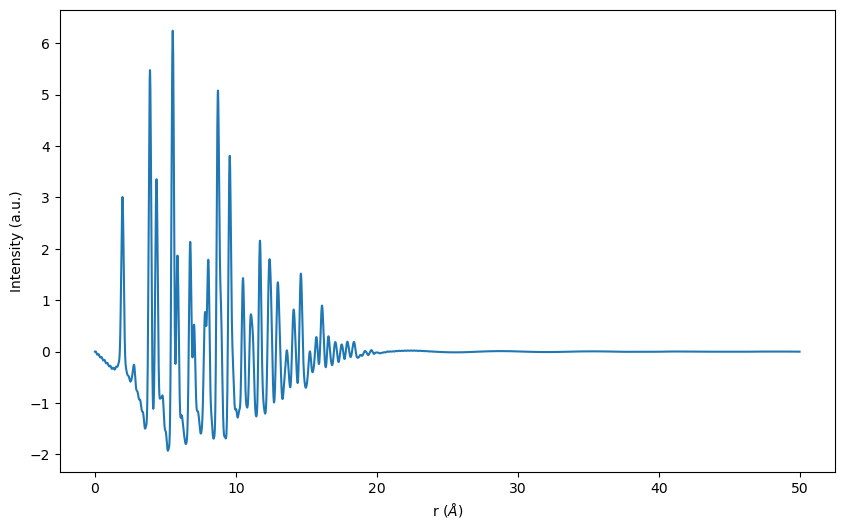

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(*dataset.get(540, split='train').y['xPDF'])
plt.ylabel('Intensity (a.u.)')
plt.xlabel('r ($\AA$)')
plt.show()

In [5]:
stats = dataset.get_statistics(return_dataframe=True)
stats.head()

idx  # of nodes  # of edges  # of elements Space group (Symbol)  \
0    0        31.0        84.0            2.0                C 2/m   
1    1       279.0       876.0            2.0                C 2/m   
2    2       875.0      2964.0            2.0                C 2/m   
3    3      2005.0      7092.0            2.0                C 2/m   
4    4      3927.0     14220.0            2.0                C 2/m   

   Space group (Number)     Crystal type  NP size (Å)  \
0                  12.0  CadmiumChloride    10.817969   
1                  12.0  CadmiumChloride    23.968044   
2                  12.0  CadmiumChloride    34.560139   
3                  12.0  CadmiumChloride    43.835541   
4                  12.0  CadmiumChloride    54.064667   

                    Elements Random data split  \
0  [tensor(9.), tensor(21.)]              Test   
1  [tensor(9.), tensor(21.)]             Train   
2  [tensor(9.), tensor(21.)]             Train   
3  [tensor(9.), tensor(21.)]             Train   
4  [tensor(9.), tensor(21.)]             Train   

  Stratified data split (Crystal type)  
0                                Train  
1                                Train  
2                                Train  
3                                Train  
4                                Train

In [6]:
stats.describe()

idx    # of nodes    # of edges  # of elements  \
count  3240.000000   3240.000000   3240.000000         3240.0   
mean   1619.500000   2207.171296   9635.504321            2.0   
std     935.451763   2333.691112  11644.764769            0.0   
min       0.000000     23.000000      0.000000            2.0   
25%     809.750000    375.000000   1128.000000            2.0   
50%    1619.500000   1387.000000   5052.000000            2.0   
75%    2429.250000   3455.500000  13974.000000            2.0   
max    3239.000000  14601.000000  96496.000000            2.0   

       Space group (Number)  NP size (Å)  
count           3240.000000  3240.000000  
mean             151.583333    33.356017  
std               89.484903    14.692912  
min               12.000000     9.429051  
25%               56.250000    22.606434  
50%              218.500000    33.514938  
75%              225.000000    44.044496  
max              227.000000    56.211433

In [7]:
stats[stats['# of edges'] == 0]

idx  # of nodes  # of edges  # of elements Space group (Symbol)  \
1230  1230        39.0         0.0            2.0              C m c m   
1231  1231       271.0         0.0            2.0              C m c m   
1232  1232       773.0         0.0            2.0              C m c m   
1233  1233      1779.0         0.0            2.0              C m c m   
1234  1234      3263.0         0.0            2.0              C m c m   
1365  1365        39.0         0.0            2.0              C m c m   
1366  1366       271.0         0.0            2.0              C m c m   
1367  1367       707.0         0.0            2.0              C m c m   
1368  1368      1441.0         0.0            2.0              C m c m   
1369  1369      2855.0         0.0            2.0              C m c m   
2560  2560        39.0         0.0            2.0              C m c m   
2561  2561       271.0         0.0            2.0              C m c m   
2562  2562       773.0         0.0            2.0              C m c m   
2563  2563      1779.0         0.0            2.0              C m c m   
2564  2564      3263.0         0.0            2.0              C m c m   

      Space group (Number)    Crystal type  NP size (Å)  \
1230                  63.0  NickelArsenide    13.401795   
1231                  63.0  NickelArsenide    24.387047   
1232                  63.0  NickelArsenide    34.764866   
1233                  63.0  NickelArsenide    44.815872   
1234                  63.0  NickelArsenide    55.000683   
1365                  63.0  NickelArsenide    14.358957   
1366                  63.0  NickelArsenide    25.771946   
1367                  63.0  NickelArsenide    35.457714   
1368                  63.0  NickelArsenide    45.516819   
1369                  63.0  NickelArsenide    55.581509   
2560                  63.0  NickelArsenide    13.449614   
2561                  63.0  NickelArsenide    24.455975   
2562                  63.0  NickelArsenide    34.892262   
2563                  63.0  NickelArsenide    44.976768   
2564                  63.0  NickelArsenide    55.119923   

                       Elements Random data split  \
1230  [tensor(9.), tensor(89.)]        Validation   
1231  [tensor(9.), tensor(89.)]             Train   
1232  [tensor(9.), tensor(89.)]             Train   
1233  [tensor(9.), tensor(89.)]              Test   
1234  [tensor(9.), tensor(89.)]        Validation   
1365  [tensor(9.), tensor(56.)]        Validation   
1366  [tensor(9.), tensor(56.)]              Test   
1367  [tensor(9.), tensor(56.)]             Train   
1368  [tensor(9.), tensor(56.)]             Train   
1369  [tensor(9.), tensor(56.)]             Train   
2560  [tensor(9.), tensor(38.)]             Train   
2561  [tensor(9.), tensor(38.)]             Train   
2562  [tensor(9.), tensor(38.)]             Train   
2563  [tensor(9.), tensor(38.)]             Train   
2564  [tensor(9.), tensor(38.)]             Train   

     Stratified data split (Crystal type)  
1230                           Validation  
1231                                Train  
1232                                Train  
1233                                Train  
1234                           Validation  
1365                                Train  
1366                           Validation  
1367                                Train  
1368                                 Test  
1369                                Train  
2560                                 Test  
2561                           Validation  
2562                                Train  
2563                           Validation  
2564                                Train

In [8]:
sns.scatterplot(data=stats, x='# of nodes', y='# of edges', hue='Crystal type')
plt.show()

In [9]:
palette = sns.color_palette('tab10')
color_dict = {'Train': palette[0], 'Validation': palette[1], 'Test': palette[2]}
hue_order = ['Train', 'Validation', 'Test']

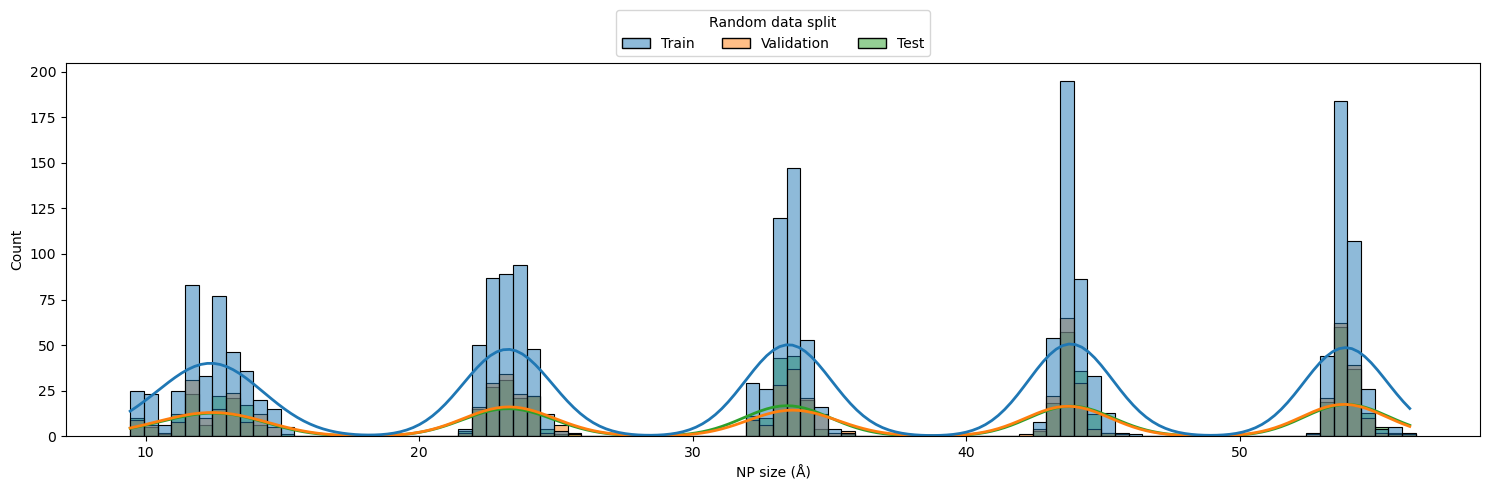

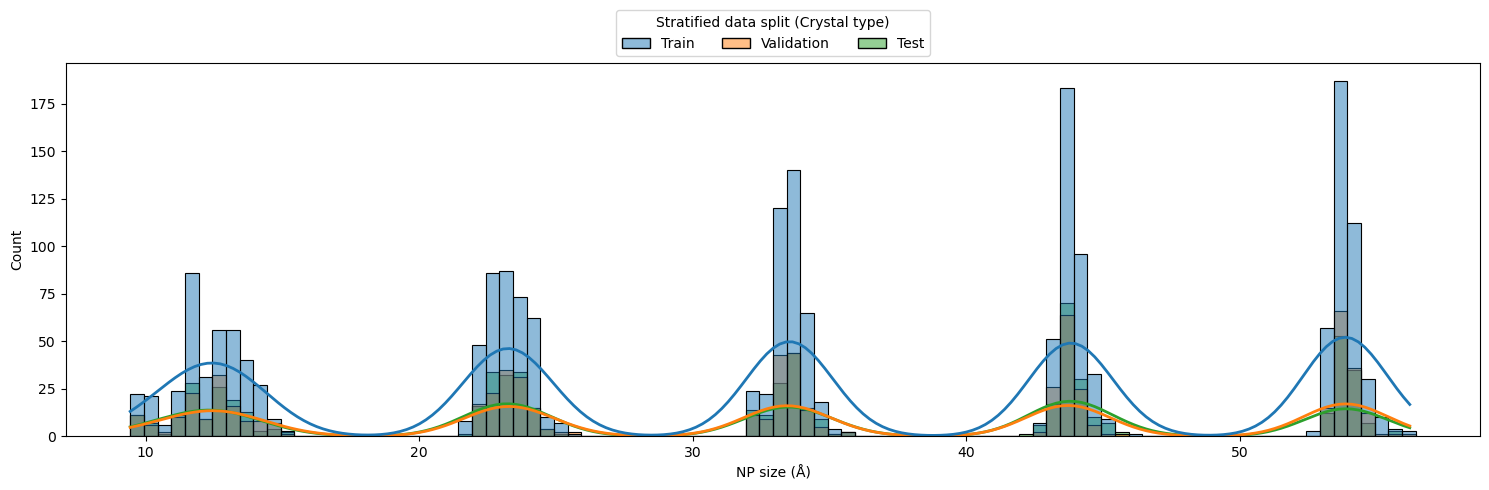

In [10]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=stats, x='NP size (Å)', binwidth=0.5, hue='Random data split', multiple='layer',kde=True, kde_kws=dict(bw_method=0.1), line_kws=dict(linewidth=2), stat='count', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_sizeDist.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(15,5))
ax = sns.histplot(data=stats, x='NP size (Å)', binwidth=0.5, hue='Stratified data split (Crystal type)', multiple='layer',kde=True, kde_kws=dict(bw_method=0.1), line_kws=dict(linewidth=2), stat='count', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_sizeDist.png', format='png', dpi=300)
plt.show()

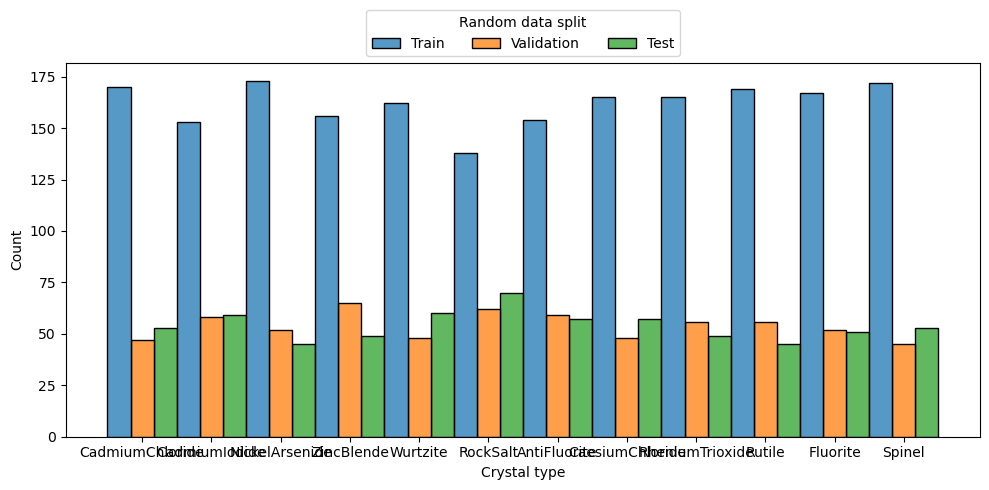

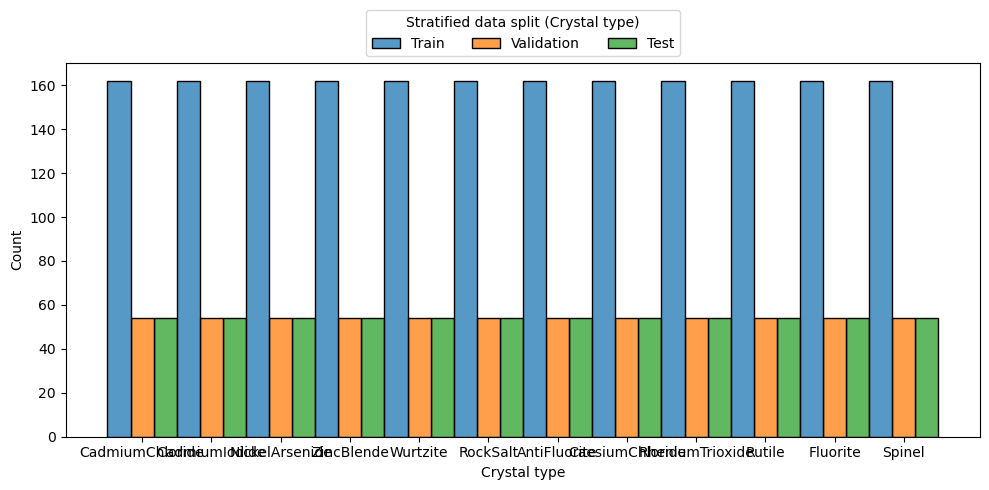

In [11]:
plt.figure(figsize=(10,5))
ax = sns.histplot(data=stats, x='Crystal type', hue='Random data split', multiple='dodge', palette=color_dict, hue_order=hue_order)
# ax = sns.histplot(data=stats, x='Crystal type', hue='Stratified data split (Crystal type)', multiple='dodge', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_crystalTypes.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(10,5))
#ax = sns.histplot(data=stats, x='Crystal type', hue='Random data split', multiple='dodge', palette=color_dict, hue_order=hue_order)
ax = sns.histplot(data=stats, x='Crystal type', hue='Stratified data split (Crystal type)', multiple='dodge', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_crystalTypes.png', format='png', dpi=300)
plt.show()

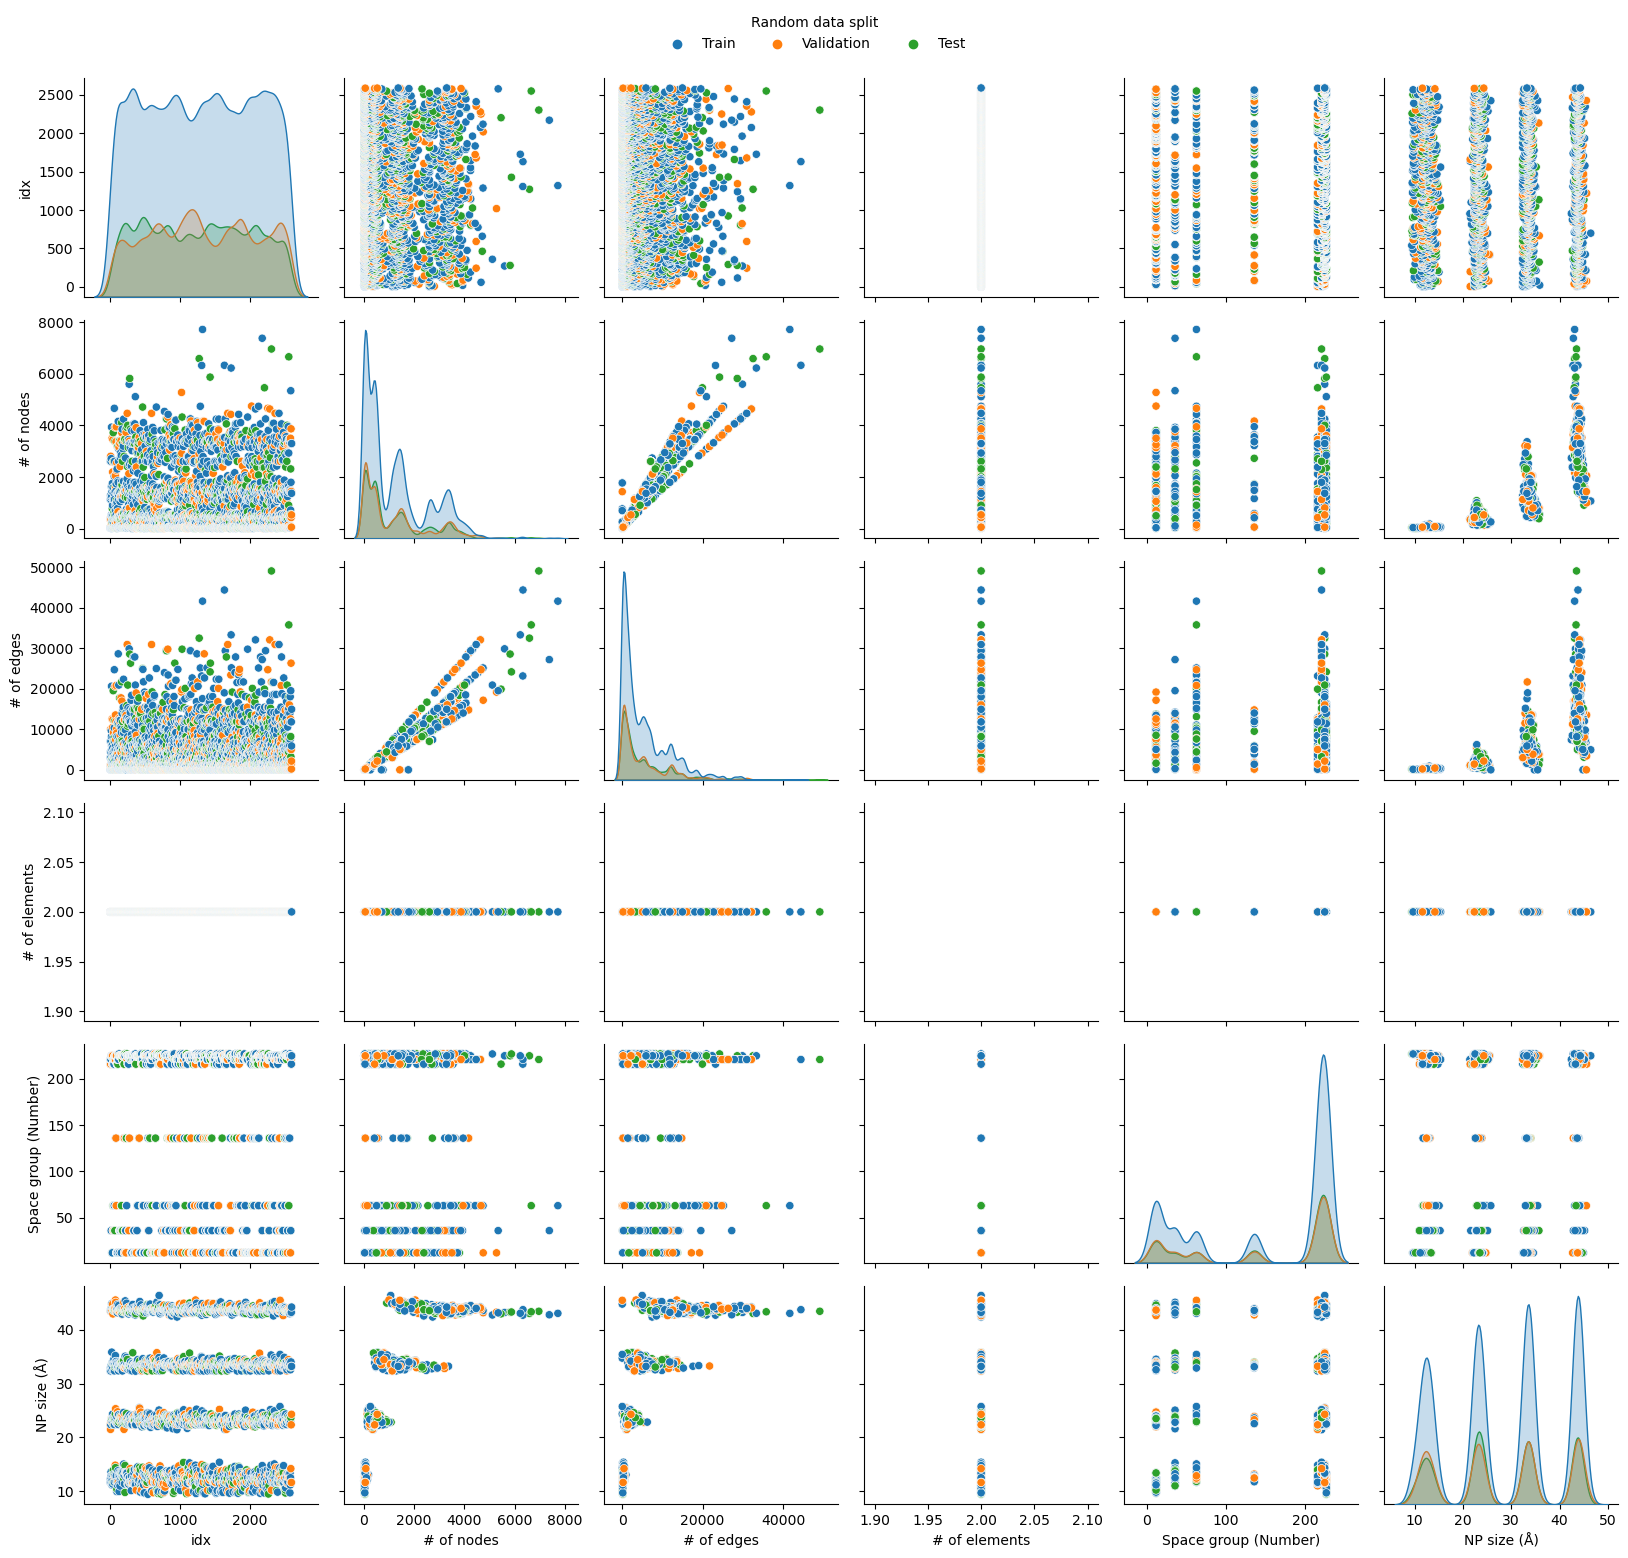

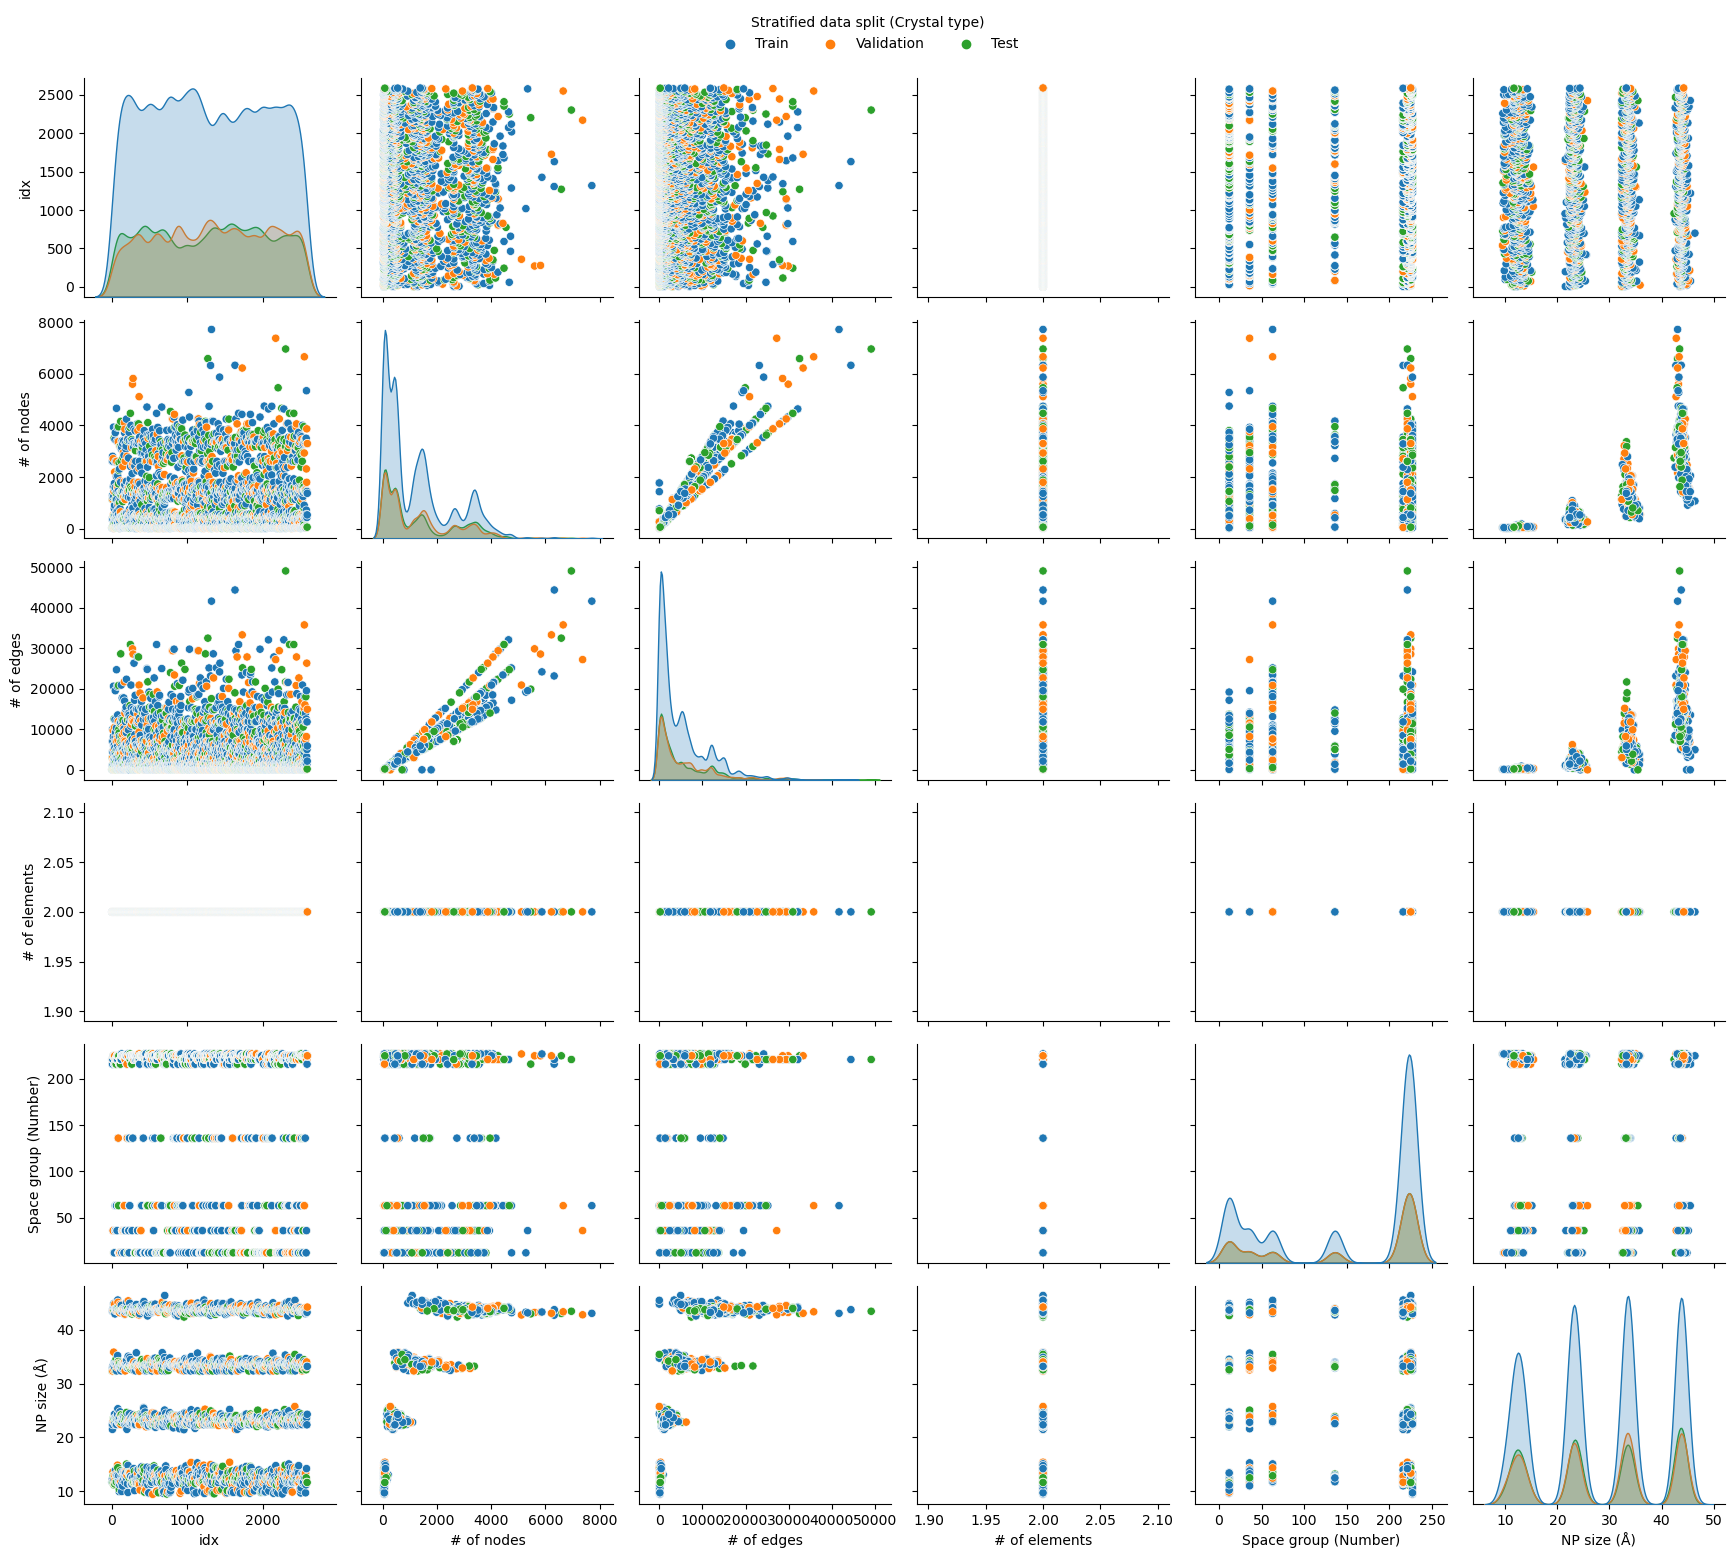

In [19]:
ax = sns.pairplot(data=stats.drop('Elements', axis=1), hue='Random data split', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), hue='Stratified data split (Crystal type)', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), diag_kws=dict(bw_method=0.1))
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_pairplot.png', format='png', dpi=300)
plt.show()

#ax = sns.pairplot(data=stats, hue='Random data split', diag_kws=dict(bw_method=0.1))
ax = sns.pairplot(data=stats.drop('Elements', axis=1), hue='Stratified data split (Crystal type)', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), diag_kws=dict(bw_method=0.1))
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_pairplot.png', format='png', dpi=300)
plt.show()

In [25]:
stats.columns

Index(['idx', '# of nodes', '# of edges', '# of elements',
       'Space group (Symbol)', 'Space group (Number)', 'Crystal type',
       'NP size (Å)', 'Elements', 'Random data split',
       'Stratified data split (Crystal type)'],
      dtype='object')